In [ ]:
%matplotlib inline
%config Completer.use_jedi=False

import lnPi
import lnPi.collectionlnpiutils
import lnPi.segment
import lnPi.stability
import numpy as np
import pandas as pd

In [ ]:
# compare to this
df = pd.read_csv("./out.ljmix4_full.t080.v512.r1.lnpi_o.dat.const_mu.csv.gz").assign(
    lnz_0=lambda x: x["beta"] * x["mu_0"],
    lnz_1=lambda x: x["beta"] * x["mu_1"],
    betaOmega=lambda x: -x["beta"] * x["pressure"] * x["volume"],
)

In [ ]:
path = "./ljmix4_full.t080.v512.r1.lnpi_o.dat.gz"
temp = 0.8
state_kws = {"temp": temp, "beta": 1.0 / temp, "volume": 512}
lnz = np.array([-2.5, -2.5])

In [ ]:
# delayed
ref = (
    lnPi.MaskedlnPiDelayed.from_table(path, state_kws=state_kws, lnz=lnz)
    .zeromax()
    .pad()
)
phase_creator = lnPi.segment.PhaseCreator(
    nmax=2, nmax_peak=4, ref=ref, merge_kws={"efac": 0.8}
)

In [ ]:
# lnzs to consider
lnzs = df[["lnz_0", "lnz_1"]].values

In [ ]:
# %%timeit -n 1 -r 1
with lnPi.set_options(
    tqdm_leave=True, joblib_use=True, tqdm_len_build=10, tqdm_bar="text"
):
    o = lnPi.CollectionlnPi.from_builder(
        lnzs[:], phase_creator.build_phases, unstack=False
    )


build: 100%|█████████████████████████████████████████████████████████████| 3999/3999 [00:17<00:00, 227.15it/s]


In [ ]:
with lnPi.set_options(tqdm_leave=True, joblib_use=False, tqdm_bar="text"):
    o.xge.pi_sum

In [ ]:
# get data to compare
table = o.xge.table(
    ["mask_stable", "dens", "betaOmega", "molfrac"], ref=ref, dim_to_suffix="component"
)
t = table.to_dataframe().query("mask_stable").reset_index()

cols = [
    "lnz_0",
    "lnz_1",
    "beta",
    "betaOmega",
    "dens_0",
    "dens_1",
    "molfrac_0",
    "molfrac_1",
    "edge_distance",
]


def _round(df):
    return df.assign(
        lnz_0=lambda x: np.round(x.lnz_0, 3), lnz_1=lambda x: np.round(x.lnz_1, 3)
    )


a = t[cols].pipe(_round).set_index(["lnz_0", "lnz_1", "beta"])
b = (
    df.rename(columns=lambda x: x.replace("density", "dens"))[cols]
    .pipe(_round)
    .set_index(["lnz_0", "lnz_1", "beta"])
)

In [ ]:
np.abs((a - b) / a).max()

betaOmega        4.906069e-11
dens_0           4.684806e-11
dens_1           4.763309e-11
molfrac_0        4.500742e-11
molfrac_1        4.797235e-11
edge_distance    4.462730e-11
dtype: float64

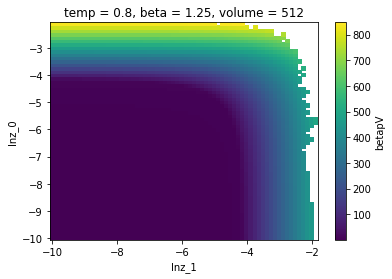

In [ ]:
(table.betapV.where(table.mask_stable).dropna("sample").unstack().min("phase").plot())

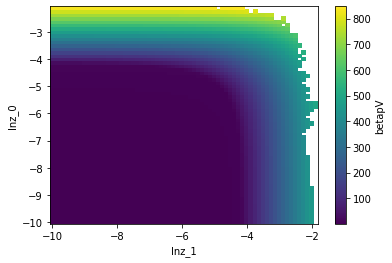

In [ ]:
(
    df[["lnz_0", "lnz_1", "betaOmega"]]
    .set_index(["lnz_0", "lnz_1"])
    .assign(betapV=lambda x: -x["betaOmega"])["betapV"]
    .to_xarray()
    .plot()
)